## A notebook for the Technical Validation part of the paper

## Import and install libraries

In [49]:
%pip install pandas seaborn matplotlib requests statsmodels
 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import requests
import matplotlib.colors as mcolors
import matplotlib as mpl
import os

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Global settings

In [50]:
# set theme
sns.set_theme(rc={'figure.figsize': (11,7)})

# Set global font sizes using rcParams
plt.rcParams.update({
    "axes.titlesize": 27,    # Font size for plot titles
    "axes.labelsize": 18,    # Font size for x and y labels
    "xtick.labelsize": 15,   # Font size for x-axis tick labels
    "ytick.labelsize": 15,  # Font size for y-axis tick labels
    "legend.fontsize": 12
})

## Growth of Uberon and CL over time from other sources

In [107]:
# load data
df_uberon_cl_growth = pd.read_csv(
    "output/other-ontologies-growth.csv", parse_dates=['date'])
df_uberon_cl_growth

,ontology,date,nodes,node_types,edges,edge_types
0,uberon,2025-01-15,15959,15965,50974,22
1,uberon,2024-11-25,15942,15948,50888,22
2,uberon,2024-09-03,15937,15943,50781,22
3,uberon,2024-08-07,15922,15928,50673,22
4,uberon,2024-07-02,15921,15927,50677,22
...,...,...,...,...,...,...
73,provisional-cell-ontology,2022-01-07,1827,1880,5142,7
74,provisional-cell-ontology,2021-12-17,1825,1875,5132,6
75,provisional-cell-ontology,2021-12-08,1824,1873,5115,5
76,provisional-cell-ontology,2021-12-03,1824,1873,5115,5


In [108]:
# make long and tidy, then sort by date
df_uberon_cl_growth_long = pd.melt(df_uberon_cl_growth, id_vars=[
                                   'ontology', 'date'], var_name='type', value_name='count')
df_uberon_cl_growth_long

,ontology,date,type,count
0,uberon,2025-01-15,nodes,15959
1,uberon,2024-11-25,nodes,15942
2,uberon,2024-09-03,nodes,15937
3,uberon,2024-08-07,nodes,15922
4,uberon,2024-07-02,nodes,15921
...,...,...,...,...
307,provisional-cell-ontology,2022-01-07,edge_types,7
308,provisional-cell-ontology,2021-12-17,edge_types,6
309,provisional-cell-ontology,2021-12-08,edge_types,5
310,provisional-cell-ontology,2021-12-03,edge_types,5


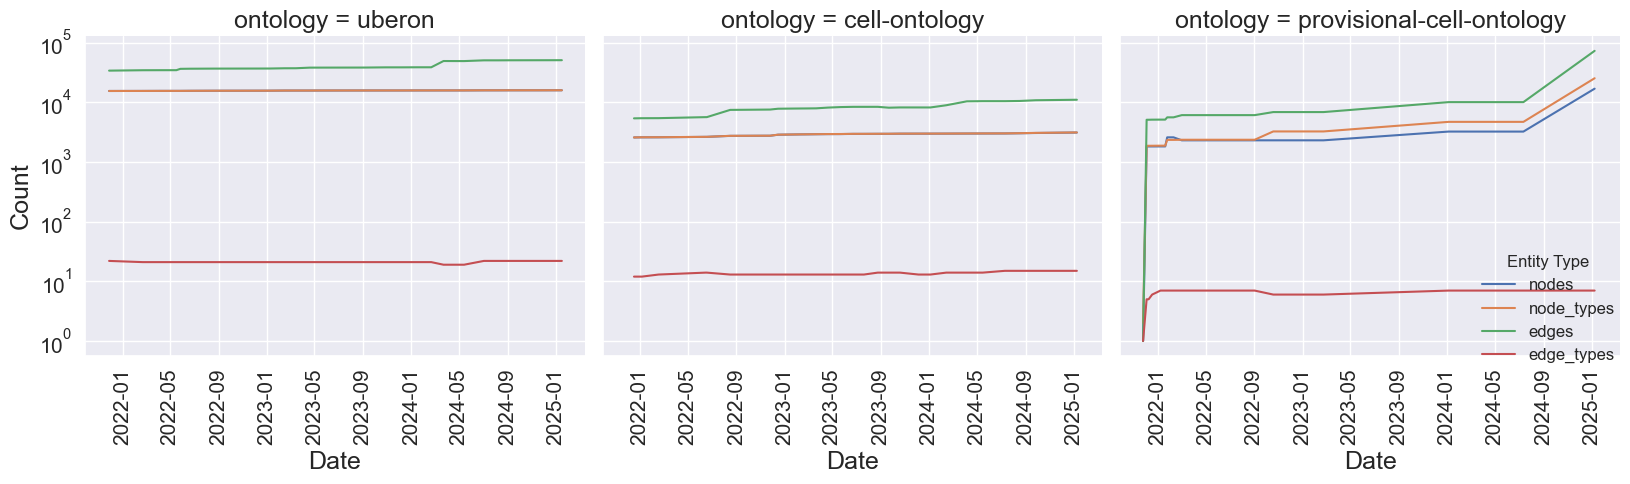

In [109]:
# visualize
g = sns.relplot(
    data=df_uberon_cl_growth_long,
  x='date',
  y='count',
  hue='type',
  col='ontology',
  kind='line'
)

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# set axis labels
g.set_xlabels('Date')
g.set_ylabels('Count')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Adjust legend
g._legend.set_bbox_to_anchor((.99, 0.35))  # Adjust position
g._legend.set_title('Entity Type')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [54]:
# compute basic stats
print('Max number of nodes per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['nodes'].max()}')
print()

print('Max number of edges per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['edges'].max()}')
print()

print('Max number of edge types per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['edge_types'].max()}')
print()

Max number of nodes per ontology:
ontology
cell-ontology                 3122
provisional-cell-ontology    16980
uberon                       15959
Name: nodes, dtype: int64

Max number of edges per ontology:
ontology
cell-ontology                 30635
provisional-cell-ontology    221269
uberon                       238139
Name: edges, dtype: int64

Max number of edge types per ontology:
ontology
cell-ontology                 58
provisional-cell-ontology     85
uberon                       171
Name: edge_types, dtype: int64



## (1) HRA growth over time

In [55]:
# import HRA growth
growth = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.csv")
growth

,group,date,count,order
0,tissue providers,2020-02-10,1,1
1,tissue providers,2020-02-12,1,1
2,tissue providers,2020-05-18,1,1
3,tissue providers,2021-02-10,1,1
4,tissue providers,2021-03-16,2,1
...,...,...,...,...
110,SOPs,2023-10-18,1,10
111,SOPs,2023-12-11,1,10
112,SOPs,2023-12-13,1,10
113,SOPs,2024-06-12,6,10


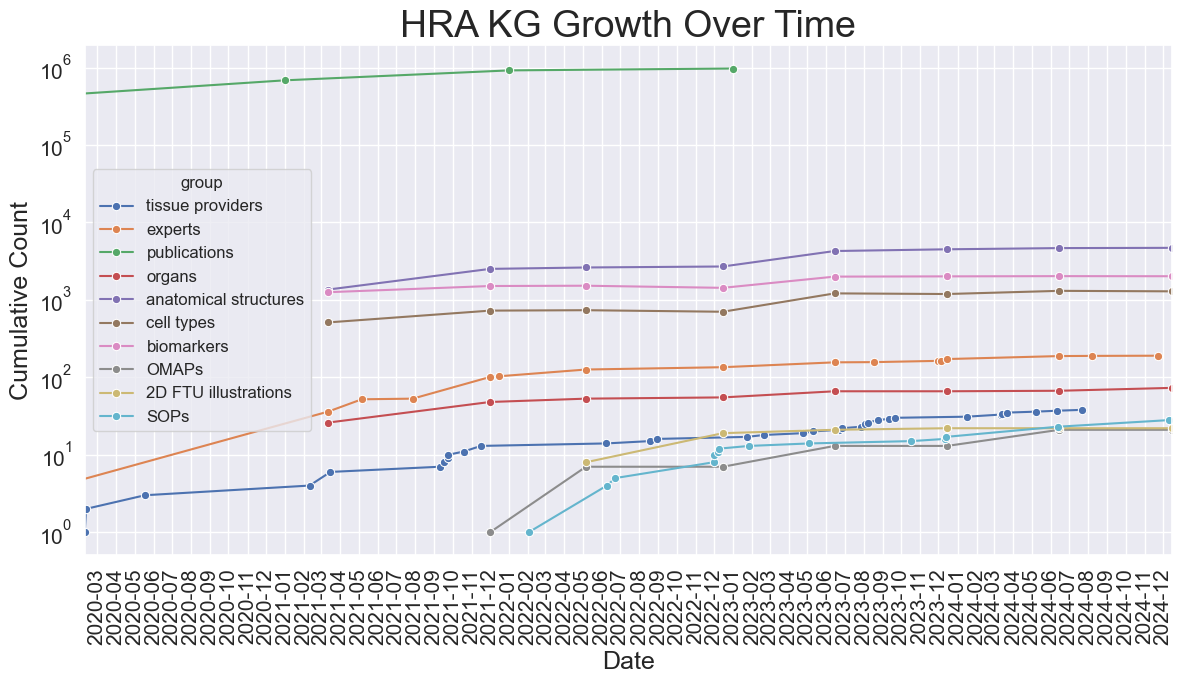

In [56]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.vl.json

# Convert date to datetime
growth['date'] = pd.to_datetime(growth['date'])

# Calculate cumulative sum
growth['cumulative_count'] = growth.groupby("group")['count'].cumsum()

# Create the line plot
g = sns.lineplot(
    data=growth,
    x='date',
    y='cumulative_count',
    hue='group',
    marker='o'
)

# Customize the plot
plt.title('HRA KG Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# increase figure size to accommodate facet grid
g.figure.set_size_inches(12, 7)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = growth.dropna()[growth['date'] >= '2020-02']
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (2) DOs per organ

In [57]:
# import DOs per organ
dos_per_organ = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.csv")
dos_per_organ

,organ,type,count
0,anatomical systems,ASCT+B Table,1
1,blood,CTAnn Crosswalks,3
2,blood pelvis,ASCT+B Table,1
3,blood vasculature,ASCT+B Table,1
4,blood vasculature,CTAnn Crosswalks,1
...,...,...,...
101,uterus,ASCT+B Table,1
102,uterus,CTAnn Crosswalks,1
103,uterus,3D Reference Organ,2
104,vascular system,CTAnn Crosswalks,1


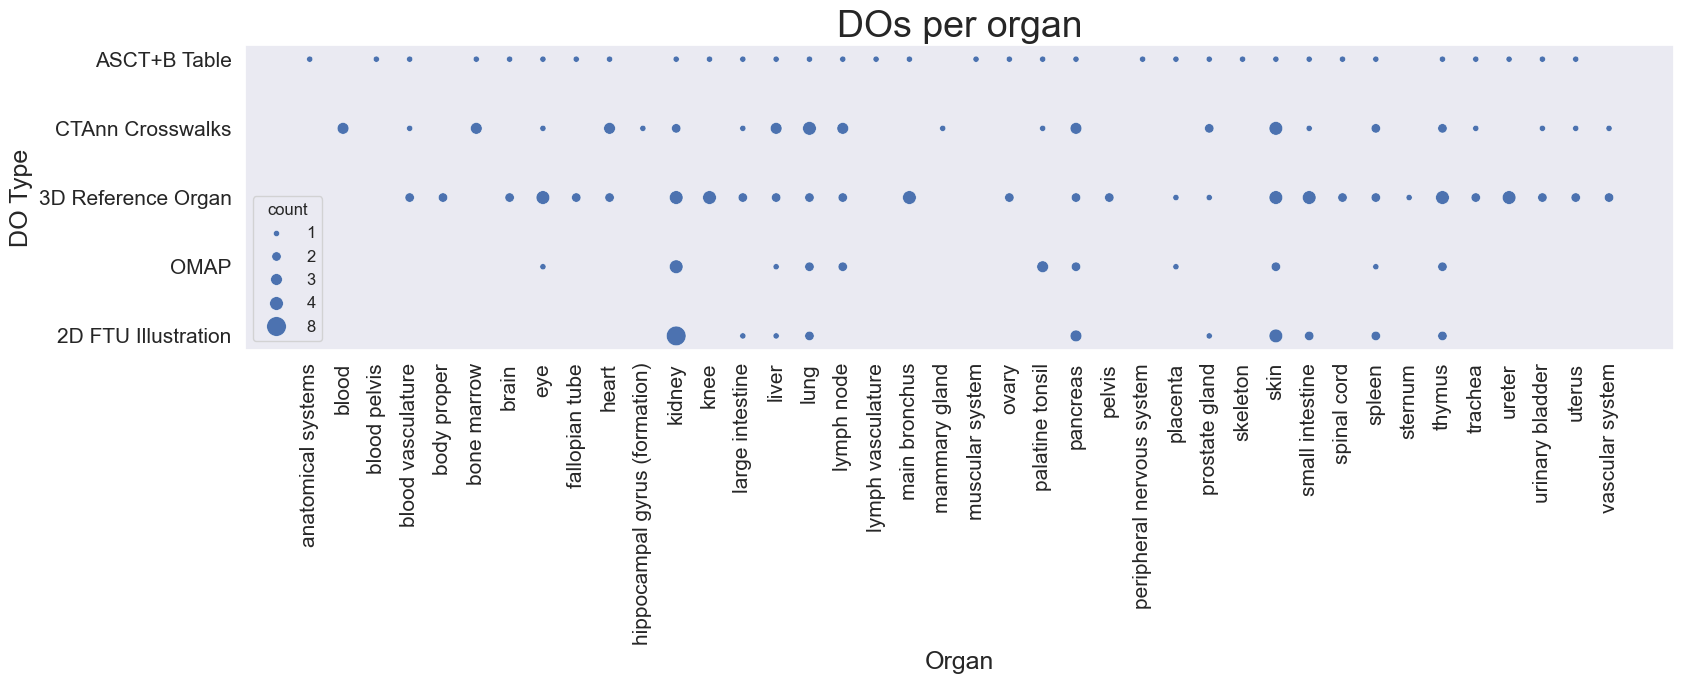

In [58]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

dos_per_organ

color_map = sns.choose_colorbrewer_palette("YlGnBu", as_cmap=True)

# Create the line plot
g = sns.scatterplot(
    data=dos_per_organ,
   x="organ",
   y="type",
   size="count",
   sizes=(20, 200)
)

# increase figure size to accommodate facet grid
g.figure.set_size_inches(17, 7)

# Customize the plot
plt.title('DOs per organ')
plt.xlabel('Organ')
plt.ylabel('DO Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Remove the grid
plt.grid(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (3) Ontology terms added over time

In [59]:
# import ontoloogies extended over time
ontology_terms_added = pd.read_csv("https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.csv")
ontology_terms_added

,date,count,ontology
0,2023-01-01,50,CL
1,2023-02-15,14,CL
2,2023-03-21,11,CL
3,2023-04-20,11,CL
4,2023-05-22,5,CL
5,2023-06-22,7,CL
6,2023-07-20,0,CL
7,2023-08-24,6,CL
8,2023-09-21,2,CL
9,2023-10-19,5,CL


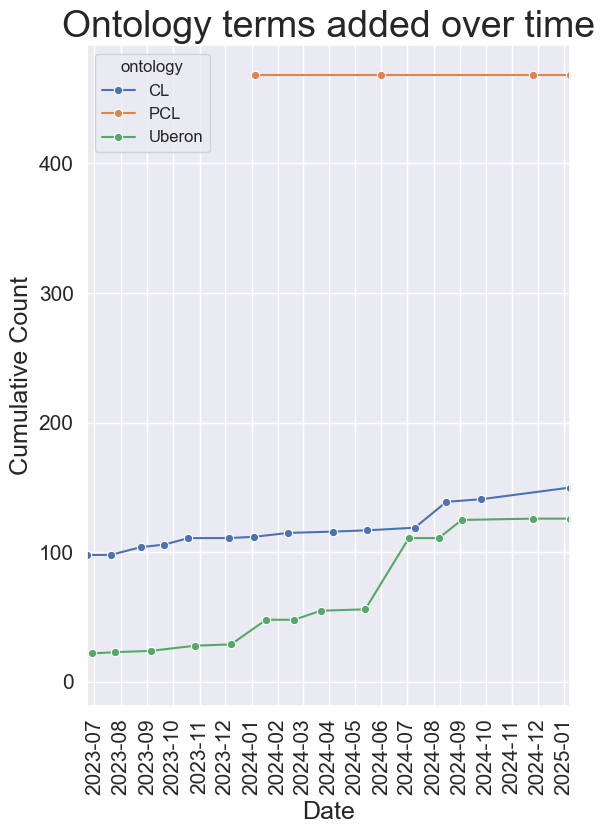

In [60]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.vl.json

# Convert date to datetime
ontology_terms_added['date'] = pd.to_datetime(ontology_terms_added['date'])

# Calculate cumulative sum
ontology_terms_added['cumulative_count'] = ontology_terms_added.groupby("ontology")[
    'count'].cumsum()

# Create the line plot
g = sns.lineplot(
    data=ontology_terms_added,
    x='date',
    y='cumulative_count',
    hue='ontology',
    marker='o'
)

# Customize the plot
plt.title('Ontology terms added over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = ontology_terms_added.dropna()[ontology_terms_added['date'] >= "2023-06"]
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# adjust figure size 
g.figure.set_size_inches(6, 8.5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (4) Terms linked to ontologies over time

### Preprocess data

In [61]:
# GitHub repository details
repo_owner = 'hubmapconsortium'
repo_name = 'ccf-validation-tools'
folder_path = 'reports'
branch = 'master' 

# GitHub API URL to get files in the folder
url = f'https://api.github.com/repos/{repo_owner}/{
    repo_name}/contents/{folder_path}?ref={branch}'

# Fetch the file list from the repository
response = requests.get(url)
files = response.json()

# initlalize list of ds to hold TSV reports
list_df_terms = []
list_df_relationships = []

# Define the folder where we want to save the reports
save_folder = "data/validation-reports/"

# Ensure the folder exists
os.makedirs(save_folder, exist_ok=True)

# collect content of save folder
files_local = [entry.name for entry in os.scandir(
    save_folder) if entry.is_file()]

# Iterate over file list from GitHub API and check for TSV files
for file in files:
  if file['name'].endswith('.tsv'):
    
    # Get URL for downloading the raw content of the file
    file_url = file['download_url']
      
    # Extract the filename from the URL
    filename = os.path.join(save_folder, file['name'])
    
    # if file DOES NOT exist locally, download it
    if (file['name'] not in files_local):
      
      # Download the file
      tsv_response = requests.get(file_url)

      # Check if the file is downloaded successfully
      if tsv_response.status_code == 200:
        tsv_data = tsv_response.text
        
        # save the data
        with open(filename, "wb") as current_file:
          for chunk in tsv_response.iter_content(1024):
            current_file.write(chunk)
          print(f"Report saved as {filename}")
    
    # if file DOES exist locally
    # Read the local TSV file into a DataFrame
    df = pd.read_csv(filename, sep='\t')

    df['Date'] = file['name'].split(
        '_')[len(file['name'].split('_'))-1].replace('.tsv', '')

    # put into list depending on file name (terms or relationships)
    if "terms" in file['name']:
      list_df_terms.append(df)
    elif "relationship" in file['name']:
      list_df_relationships.append(df)
    else:
      print(f"Failed to turn {file['name']} into a DataFrame")
          
print(f'Length of list_df_terms: {len(list_df_terms)}')
print(f'Length of list_df_relationships: {len(list_df_relationships)}')

Length of list_df_terms: 165
Length of list_df_relationships: 163


### Inspect relationships

In [62]:
list_df_relationships[5].columns

Index(['Table', 'number_of_AS-AS_relationships',
       'percent_invalid_AS-AS_relationship',
       'percent_indirect_AS-AS_relationship', 'number_of_CT-CT_relationships',
       'percent_invalid_CT-CT_relationship',
       'percent_indirect_CT-CT_relationship', 'number_of_CT-AS_relationships',
       'percent_invalid_CT-AS_relationship', 'Date'],
      dtype='object')

In [63]:
list_df_relationships[6].columns

Index(['Table', 'number_of_AS-AS_relationships',
       'percent_invalid_AS-AS_relationship',
       'percent_indirect_AS-AS_relationship', 'number_of_CT-CT_relationships',
       'percent_invalid_CT-CT_relationship',
       'percent_indirect_CT-CT_relationship', 'number_of_CT-AS_relationships',
       'percent_invalid_CT-AS_relationship', 'Date'],
      dtype='object')

In [64]:
list_df_relationships[160].columns

Index(['Table', 'number_of_AS-AS_relationships',
       'percent_invalid_AS-AS_relationship',
       'percent_indirect_AS-AS_relationship', 'number_of_CT-CT_relationships',
       'percent_invalid_CT-CT_relationship',
       'percent_indirect_CT-CT_relationship', 'number_of_CT-AS_relationships',
       'percent_invalid_CT-AS_relationship',
       'number_of_no_parent_relationships', 'unique_no_parent_relationships',
       'Date'],
      dtype='object')

### Inspect terms

In [65]:
list_df_terms[5].columns

Index(['Table', 'AS_invalid_term_number', 'AS_invalid_term_percent',
       'CT_invalid_term_number', 'CT_invalid_term_percent', 'Date'],
      dtype='object')

In [66]:
list_df_terms[6].columns

Index(['Table', 'AS_valid_term_number', 'AS_invalid_term_number',
       'AS_invalid_term_percent', 'CT_valid_term_number',
       'CT_invalid_term_number', 'CT_invalid_term_percent', 'Date'],
      dtype='object')

In [67]:
list_df_terms[162].columns

Index(['Table', 'AS_valid_term_number', 'AS_temp_term_number', 'AS_out_ub',
       'AS_invalid_term_number', 'AS_invalid_term_percent',
       'CT_valid_term_number', 'CT_temp_term_number', 'CT_out_ub',
       'CT_invalid_term_number', 'CT_invalid_term_percent',
       'invalid_terms_percent', 'Date'],
      dtype='object')

### Visualize

In [68]:
to_visualize = "terms" 
# to_visualize = "relationships"
keep = [] 
df_to_start = ""

if(to_visualize == "terms"):
  keep = ['Date', 
          'Table', 
          # 'AS_valid_term_number', 'AS_invalid_term_number', 'CT_valid_term_number', 'CT_invalid_term_number', 
          'AS_invalid_term_percent', 'CT_invalid_term_percent',
          ]
  df_to_start = list_df_terms

elif(to_visualize == "relationships"):
  keep = ['Date',
          'Table',
          'percent_invalid_AS-AS_relationship', 'percent_invalid_CT-CT_relationship', 'percent_invalid_CT-AS_relationship'
          ]
  df_to_start = list_df_relationships

merged_df = df_to_start[6]

for i, df in enumerate(df_to_start[7:], 7):
  merged_df = pd.merge(merged_df, df, on=keep, how="outer", suffixes=('_df1' + str(i-1), '_df2' +str(i)))

merged_df = merged_df[keep]

merged_df

,Date,Table,AS_invalid_term_percent,CT_invalid_term_percent
0,20211116,Blood,0.00,12.90
1,20211116,Bone-Marrow,0.00,22.45
2,20211116,Brain,20.32,40.97
3,20211116,Eye,2.56,28.21
4,20211116,Fallopian_tube,53.95,28.95
...,...,...,...,...
4985,20250212,Thymus,0.00,0.00
4986,20250212,Trachea,0.00,0.00
4987,20250212,Ureter,9.09,73.33
4988,20250212,Urinary_bladder,5.26,60.47


In [69]:
# Melt the DataFrame
merged_df_long = merged_df.melt(
    id_vars=['Date','Table'], var_name='Term', value_name='count')
merged_df_long

,Date,Table,Term,count
0,20211116,Blood,AS_invalid_term_percent,0.00
1,20211116,Bone-Marrow,AS_invalid_term_percent,0.00
2,20211116,Brain,AS_invalid_term_percent,20.32
3,20211116,Eye,AS_invalid_term_percent,2.56
4,20211116,Fallopian_tube,AS_invalid_term_percent,53.95
...,...,...,...,...
9975,20250212,Thymus,CT_invalid_term_percent,0.00
9976,20250212,Trachea,CT_invalid_term_percent,0.00
9977,20250212,Ureter,CT_invalid_term_percent,73.33
9978,20250212,Urinary_bladder,CT_invalid_term_percent,60.47


In [70]:
merged_df_long['Type'] = merged_df_long['Term'].apply(lambda t: "AS" if "AS" in t else "CT")

In [71]:
# Convert date to datetime
merged_df_long['Date'] = pd.to_datetime(
    merged_df_long['Date'], format='%Y%m%d')

merged_df_long['Date']

0      2021-11-16
1      2021-11-16
2      2021-11-16
3      2021-11-16
4      2021-11-16
          ...    
9975   2025-02-12
9976   2025-02-12
9977   2025-02-12
9978   2025-02-12
9979   2025-02-12
Name: Date, Length: 9980, dtype: datetime64[ns]

In [72]:
# prepare filtering
merged_df_long_filtered = merged_df_long.copy()

In [73]:
# filter as needed
# remove brain, PNS, blood vasculature
merged_df_long_filtered = merged_df_long[(
    merged_df_long['Table'] == 'Lung') | (merged_df_long['Table'] == "Kidney") | (merged_df_long['Table'] == "Lymph_node") | (merged_df_long['Table'] == "Pancreas")
                                        #  & (merged_df_long['Table'] != 'Peripheral_nervous_system') & (merged_df_long['Table'] != 'Blood_vasculature')
                                         ]

merged_df_long_filtered

,Date,Table,Term,count,Type
6,2021-11-16,Kidney,AS_invalid_term_percent,5.65,AS
9,2021-11-16,Lung,AS_invalid_term_percent,40.00,AS
10,2021-11-16,Lymph_node,AS_invalid_term_percent,1.87,AS
13,2021-11-16,Pancreas,AS_invalid_term_percent,6.78,AS
29,2021-11-18,Kidney,AS_invalid_term_percent,2.17,AS
...,...,...,...,...,...
9932,2025-02-05,Pancreas,CT_invalid_term_percent,6.67,CT
9954,2025-02-12,Kidney,CT_invalid_term_percent,4.29,CT
9958,2025-02-12,Lung,CT_invalid_term_percent,0.00,CT
9959,2025-02-12,Lymph_node,CT_invalid_term_percent,0.00,CT


In [74]:
merged_df_long_filtered

,Date,Table,Term,count,Type
6,2021-11-16,Kidney,AS_invalid_term_percent,5.65,AS
9,2021-11-16,Lung,AS_invalid_term_percent,40.00,AS
10,2021-11-16,Lymph_node,AS_invalid_term_percent,1.87,AS
13,2021-11-16,Pancreas,AS_invalid_term_percent,6.78,AS
29,2021-11-18,Kidney,AS_invalid_term_percent,2.17,AS
...,...,...,...,...,...
9932,2025-02-05,Pancreas,CT_invalid_term_percent,6.67,CT
9954,2025-02-12,Kidney,CT_invalid_term_percent,4.29,CT
9958,2025-02-12,Lung,CT_invalid_term_percent,0.00,CT
9959,2025-02-12,Lymph_node,CT_invalid_term_percent,0.00,CT


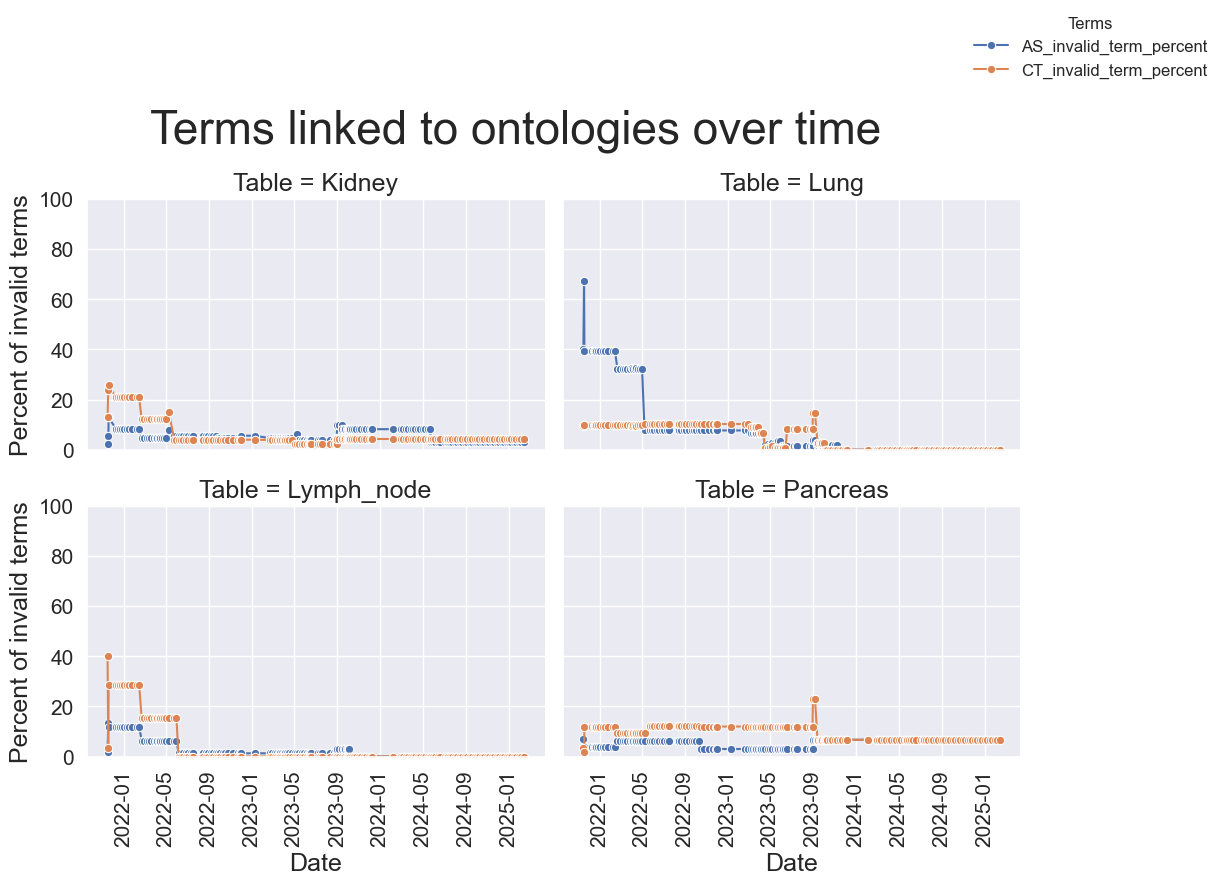

In [75]:
# make combined line graph

# palette = sns.color_palette('Paired')
palette = ["#33a02c", "#e31a1c", "#1f78b4", "#ff7f00"] # uses colors from Color Brewer palettes

# Create FacetGrid
g = sns.FacetGrid(
    merged_df_long_filtered,
  col='Table',
  height=4, 
  col_wrap=2,
  sharey=True
  )

# Create the line plot
g.map(
  sns.lineplot,
    'Date',
    'count',
    'Term',
    # palette=palette,
    marker='o'
)

# limit y axis (if using percentages)
plt.ylim([0, 100])

# Customize the plot
g.fig.suptitle("Terms linked to ontologies over time", fontsize=33)
g.set_ylabels('Percent of invalid terms')
plt.xlabel('Date')

# add legend
g.add_legend(title='Terms',
             bbox_to_anchor=(1.05, 1),
             loc='lower center')

for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

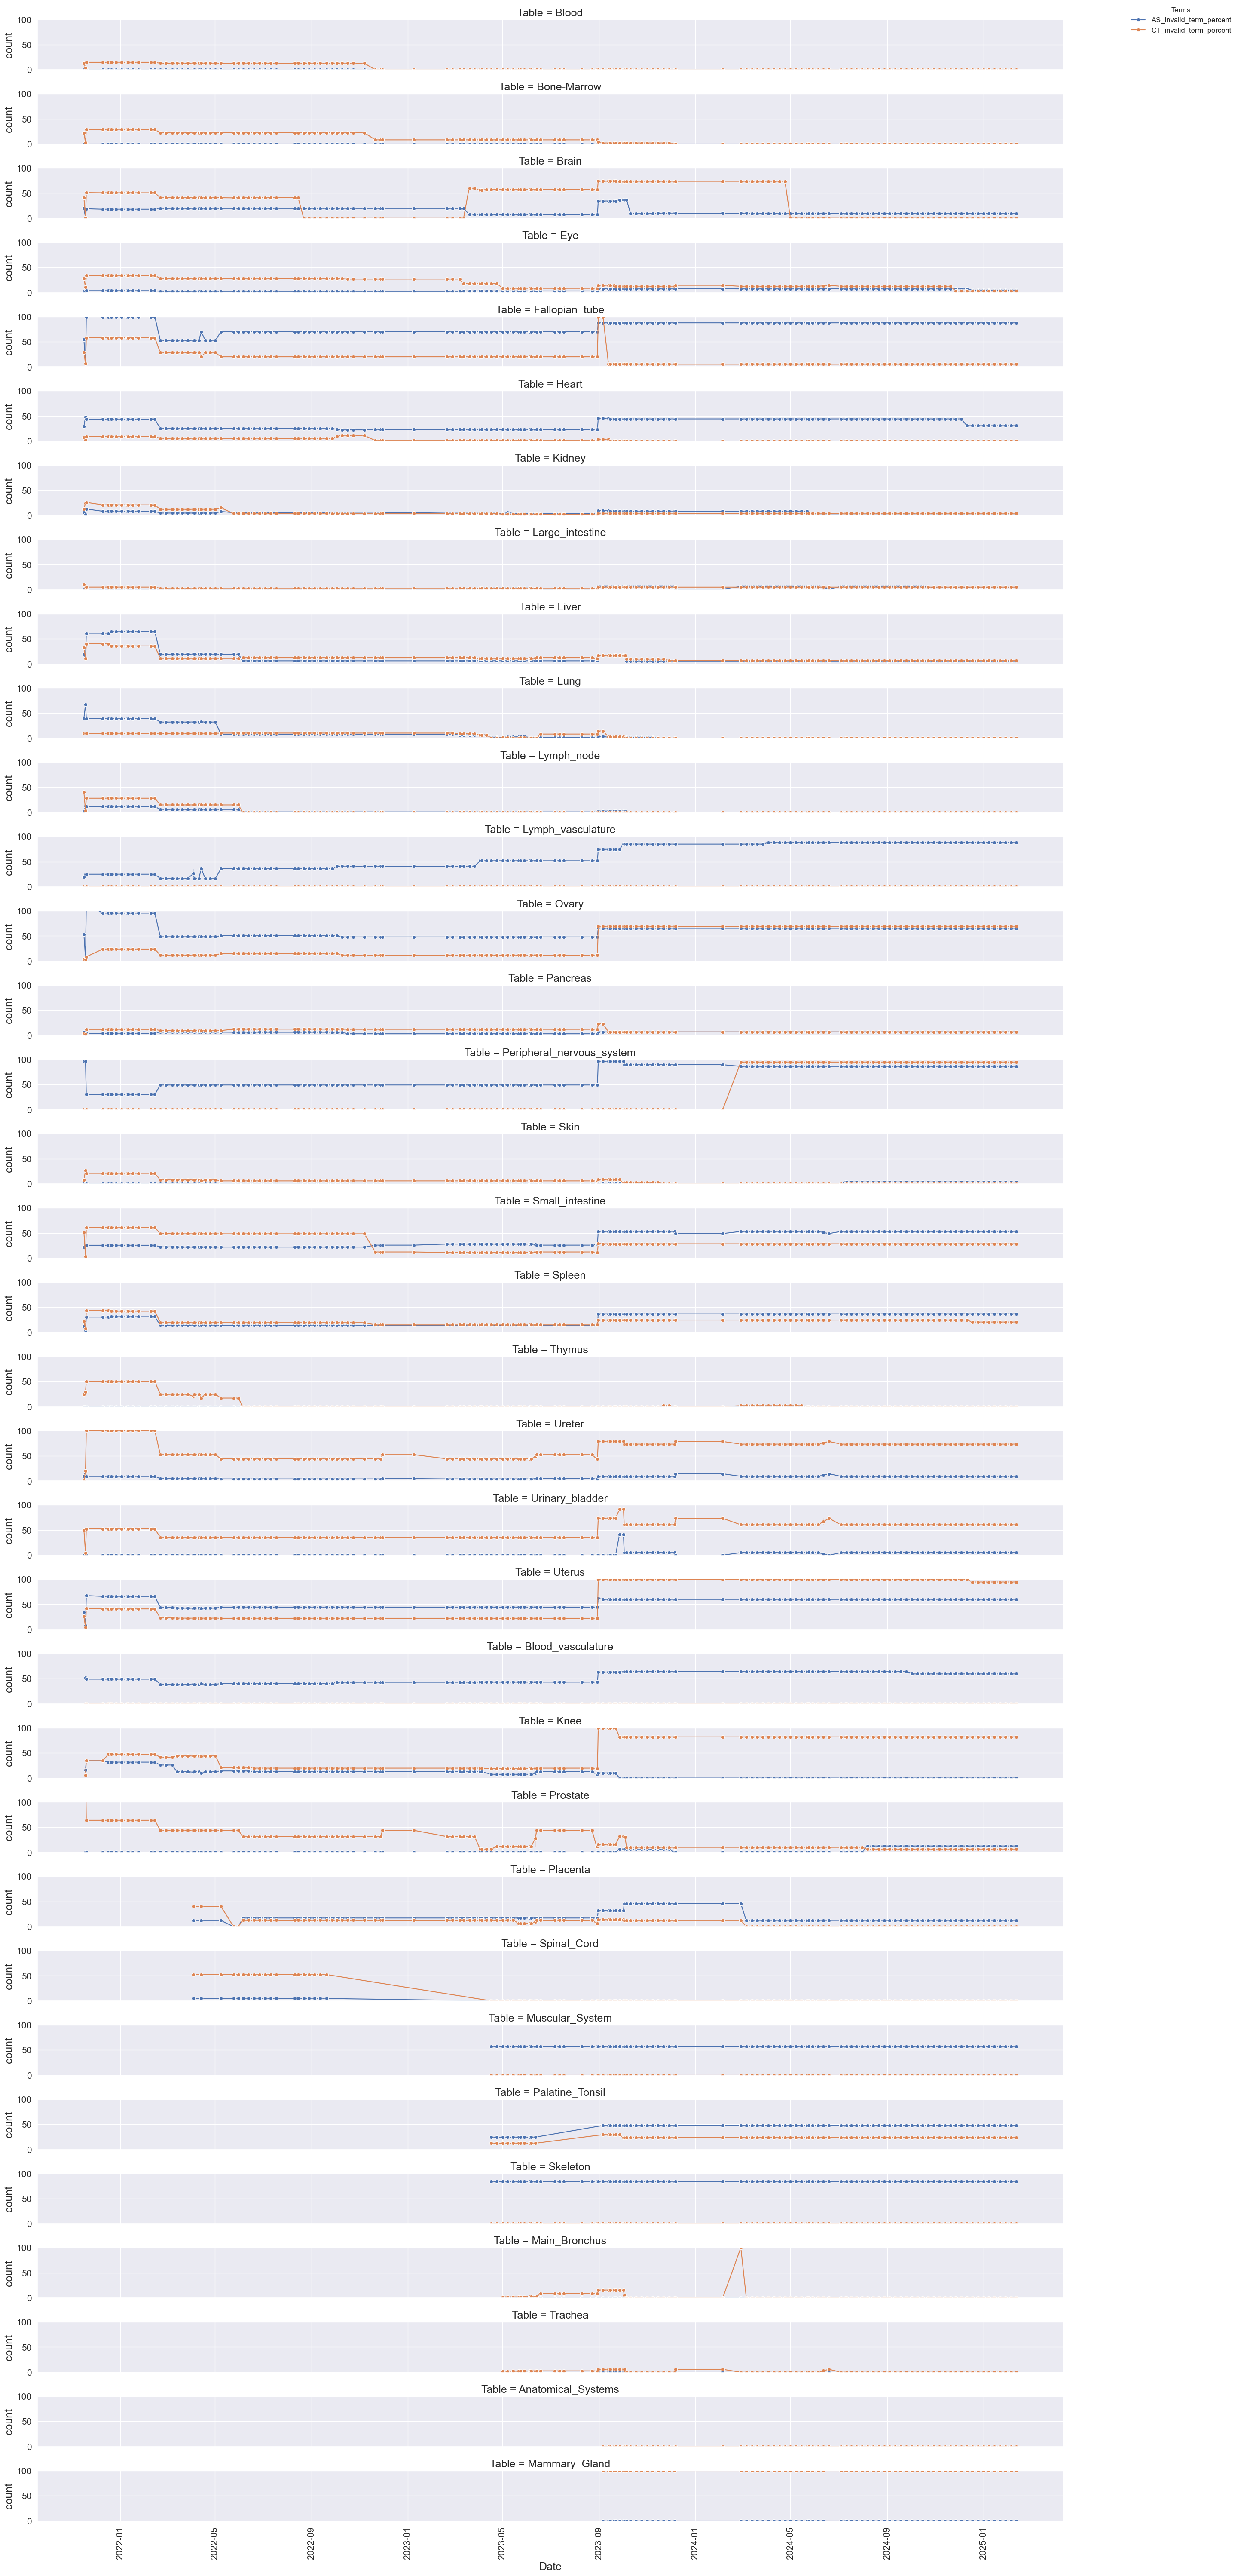

In [76]:
g = sns.FacetGrid(
    merged_df_long,
    row='Table',
    sharey=True,
    sharex=True)

g.map(
    sns.lineplot,
    'Date',
    'count',
    'Term',
    marker='o'
    )

# add legend
g.add_legend(title='Terms',    
             bbox_to_anchor=(1.05, 1), 
             loc='upper left')         

# increase figure size to accommodate facet grid
g.figure.set_size_inches(25, 60)

for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

# limit y axis (if using percentages)
plt.ylim([0,100])

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [77]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [78]:
hex_values = [mcolors.to_hex(color) for color in sns.color_palette("Paired")]
hex_values

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [79]:
# get stats for examples to highlight
df_latest = merged_df[
    merged_df['Date'] == merged_df['Date'].max()]
df_latest

,Date,Table,AS_invalid_term_percent,CT_invalid_term_percent
4956,20250212,Anatomical_Systems,0.00,0.00
4957,20250212,Blood,0.00,0.00
4958,20250212,Blood_vasculature,59.41,0.00
4959,20250212,Bone-Marrow,0.00,0.00
4960,20250212,Brain,9.47,0.00
4961,20250212,Eye,4.88,2.94
4962,20250212,Fallopian_tube,87.50,5.26
4963,20250212,Heart,30.61,0.00
4964,20250212,Kidney,3.28,4.29
4965,20250212,Knee,0.00,81.82


In [80]:
# concatenate
df_concat = pd.concat([list_df_terms[len(list_df_terms)-1],
                      list_df_relationships[len(list_df_relationships)-1]], axis=1)
df_concat = df_concat[[
    'Date', 'Table', 'AS_invalid_term_percent', 'CT_invalid_term_percent', 'percent_invalid_AS-AS_relationship', 'percent_invalid_CT-CT_relationship', 'percent_invalid_CT-AS_relationship']]
df_concat = df_concat.loc[:, ~df_concat.columns.duplicated()]
df_concat

,Date,Table,AS_invalid_term_percent,CT_invalid_term_percent,percent_invalid_AS-AS_relationship,percent_invalid_CT-CT_relationship,percent_invalid_CT-AS_relationship
0,20250212,Anatomical_Systems,0.00,0.00,1.90,0.00,0.00
1,20250212,Blood,0.00,0.00,0.00,26.09,100.00
2,20250212,Bone-Marrow,0.00,0.00,0.00,40.48,95.24
3,20250212,Brain,9.47,0.00,25.71,5.65,45.07
4,20250212,Eye,4.88,2.94,28.95,11.76,51.52
5,20250212,Fallopian_tube,87.50,5.26,28.57,0.00,94.92
6,20250212,Heart,30.61,0.00,59.57,0.00,85.71
7,20250212,Kidney,3.28,4.29,30.00,0.00,26.09
8,20250212,Knee,0.00,81.82,50.00,100.00,50.00
9,20250212,Large_intestine,4.76,5.17,85.14,0.00,80.79


In [81]:
# export to CSV
df_concat.to_csv("output/Table4.csv", index=False)

In [82]:
df_melted = df_latest.melt(id_vars=['Date', 'Table'],
                    value_vars=keep,
                    var_name='Type',
                    value_name='Invalid_Term_Percent')
df_melted

,Date,Table,Type,Invalid_Term_Percent
0,20250212,Anatomical_Systems,AS_invalid_term_percent,0.00
1,20250212,Blood,AS_invalid_term_percent,0.00
2,20250212,Blood_vasculature,AS_invalid_term_percent,59.41
3,20250212,Bone-Marrow,AS_invalid_term_percent,0.00
4,20250212,Brain,AS_invalid_term_percent,9.47
...,...,...,...,...
63,20250212,Thymus,CT_invalid_term_percent,0.00
64,20250212,Trachea,CT_invalid_term_percent,0.00
65,20250212,Ureter,CT_invalid_term_percent,73.33
66,20250212,Urinary_bladder,CT_invalid_term_percent,60.47


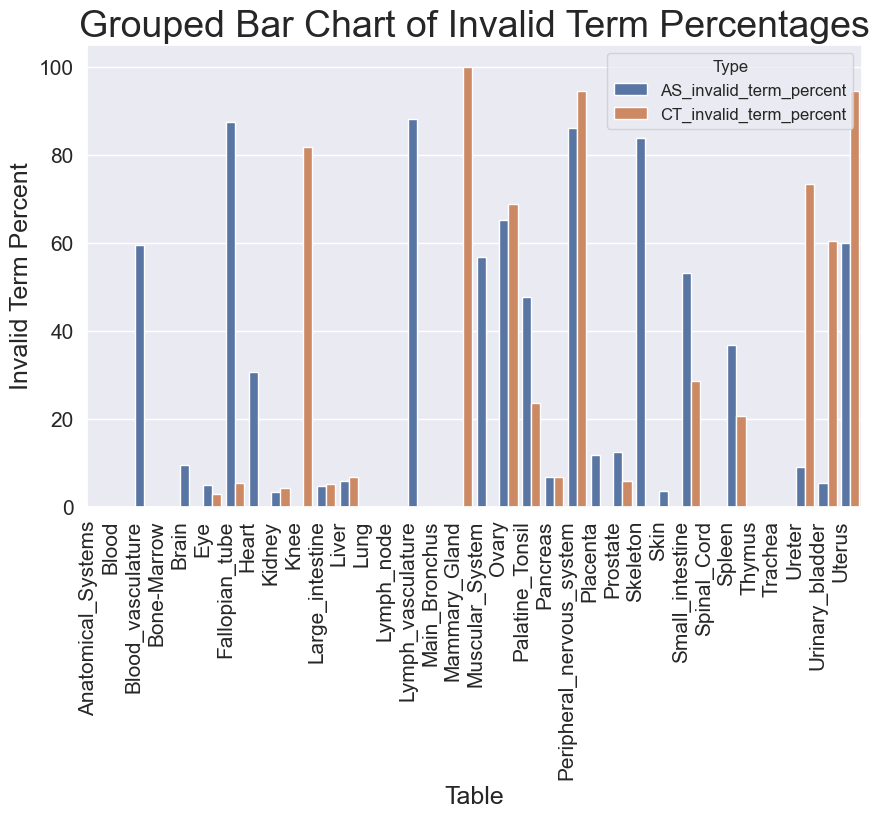

In [83]:
# Create the grouped bar plot
plt.figure(figsize=(10, 6))
g = sns.barplot(data=df_melted, x='Table', y='Invalid_Term_Percent', hue='Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')
plt.xlabel("Table")
plt.ylabel("Invalid Term Percent")
plt.title("Grouped Bar Chart of Invalid Term Percentages")
plt.legend(title="Type")

# Show the plot
plt.show()
